**AIT 511 — MACHINE LEARNING PROJECT**

**TOPIC: OBESITY RISK PREDICTION (KAGGLE)**

**TEAM MEMBERS: MT2025008, MT2025059**


**Upload Dataset**

In [1]:
#Obesity Risk Prediction
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


**Load Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

**Load Data**

In [3]:
train = pd.read_csv("train.csv")# Reading training and test data
test = pd.read_csv("test.csv")
test_ids = test["id"]# Keeping test IDs for final submission
# Removing ID column from train and test
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

**DATA shape and Basic Overview of data**

In [4]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("\nColumns:", train.columns.tolist())
print("\nMissing values:\n", train.isnull().sum())

Train shape: (15533, 18)
Test shape: (5225, 17)

Columns: ['id', 'Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'WeightCategory']

Missing values:
 id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
WeightCategory                    0
dtype: int64


In [5]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


**Exploratory Data Analysis(EDA)**

**Data Preprocessing**

In [6]:
# Converting Yes/No columns to 1/0
yes_no_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
for col in yes_no_cols:
    train[col] = train[col].map({'yes': 1, 'no': 0})
    test[col] = test[col].map({'yes': 1, 'no': 0})

In [7]:
# Frequency-type categorical mapping
mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
for col in ['CAEC', 'CALC']:
    train[col] = train[col].map(mapping)
    test[col] = test[col].map(mapping)

In [8]:
# Encode transport column (MTRANS)
le_mtrans = LabelEncoder()
combined_transport = pd.concat([train['MTRANS'], test['MTRANS']], axis=0)
le_mtrans.fit(combined_transport)
train['MTRANS'] = le_mtrans.transform(train['MTRANS'])
test['MTRANS'] = le_mtrans.transform(test['MTRANS'])

In [9]:
# Encode target
le_weight = LabelEncoder()
train['WeightCategory'] = le_weight.fit_transform(train['WeightCategory'])
print("\ncomplete!")


complete!


**Train–Validation Split**

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [29]:
# Separating input and target
X = train.drop(columns=['WeightCategory'])
y = train['WeightCategory']

# Spliting into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {X_train.shape}, Validation size: {X_val.shape}")


Train size: (12426, 17), Validation size: (3107, 17)


In [30]:
# Encode categorical columns
for col in X_train.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.transform(X_val[col])

**XGBoost Parameters**

In [31]:
#  Defining refined XGBoost parameters

refined_params = {
    'objective': 'multi:softmax',   # multi-class classification
    'num_class': len(np.unique(y)), # number of output categories
    'eval_metric': 'mlogloss',      # loss function to evaluate
    'use_label_encoder': False,     # avoid old warnings
    'tree_method': 'hist',          # fast histogram-based algorithm
    'grow_policy': 'lossguide',     # builds deeper trees efficiently
    'random_state': 42,             # for reproducibility

    # Fine-tuned hyperparameters
    'learning_rate': 0.021,         # how fast model learns (lower = slower, more stable)
    'max_depth': 6,                 # max depth of each tree
    'min_child_weight': 2,          # minimum data in a leaf
    'subsample': 0.71,              # fraction of training data per tree
    'colsample_bytree': 0.74,       # fraction of features per tree
    'gamma': 0.8,                   # controls overfitting
    'reg_lambda': 2.4,              # L2 regularization
    'reg_alpha': 0.22,              # L1 regularization
    'max_bin': 290                  # how fine-grained histogram splits are
}

In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
best_acc = 0.0  # Manual early stopping
best_n = None
best_model = None
accuracy_scores = []

In [34]:
refined_params.pop('n_estimators', None)

n_estimator_values = [900, 1000, 1100, 1200, 1220, 1230, 1250, 1270, 1300, 1400]
# Loop through different n_estimators values
for n in n_estimator_values:
    temp_model = XGBClassifier(**refined_params, n_estimators=n)
    temp_model.fit(X_train, y_train)

    preds = temp_model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    accuracy_scores.append(acc)

    print(f"n_estimators={n} → Validation Accuracy: {acc*100:.3f}%")

     # Keep track of best performing model
    if acc > best_acc:
        best_acc = acc
        best_n = n
        best_model = temp_model

print(f"\n=== Best Model Summary ===")
print(f"Best Validation Accuracy: {best_acc*100:.3f}%")
print(f"Best n_estimators: {best_n}")


n_estimators=900 → Validation Accuracy: 90.441%
n_estimators=1000 → Validation Accuracy: 90.409%
n_estimators=1100 → Validation Accuracy: 90.505%
n_estimators=1200 → Validation Accuracy: 90.473%
n_estimators=1220 → Validation Accuracy: 90.441%
n_estimators=1230 → Validation Accuracy: 90.473%
n_estimators=1250 → Validation Accuracy: 90.505%
n_estimators=1270 → Validation Accuracy: 90.441%
n_estimators=1300 → Validation Accuracy: 90.409%
n_estimators=1400 → Validation Accuracy: 90.473%

=== Best Model Summary ===
Best Validation Accuracy: 90.505%
Best n_estimators: 1100


**Retrain Final Model on Full Data**

In [37]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Make a copy of X to avoid modifying original dataframe
X_full = X.copy()
y_full = y.copy()

# Encode categorical columns
for col in X_full.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_full[col] = le.fit_transform(X_full[col])

# Add best n_estimators to parameters
refined_params['n_estimators'] = best_n

# Train final model on full dataset
final_model = XGBClassifier(**refined_params)
final_model.fit(X_full, y_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.74, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.8,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.021, max_bin=290,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1100, n_jobs=None, num_class=7, ...)

**Predictions on Test Set**

In [40]:
# Make a copy of the test set
X_test = test.copy()

# Encode categorical columns in test set
for col in X_test.select_dtypes(include='object').columns:
    le = LabelEncoder()
    # Fit-transform on training data, transform on test
    # Here, we assume you have stored the mapping from training
    # If not, simplest is to fit on test too (may cause mismatch)
    X_test[col] = le.fit_transform(X_test[col])

# Predict on test data
test_preds = final_model.predict(X_test)

# Decode labels back to original
pred_labels = le_weight.inverse_transform(test_preds)

# Prepare submission
submission = pd.DataFrame({
    "id": test_ids,
    "WeightCategory": pred_labels
})

submission.to_csv("submission_final.csv", index=False)
print("Submission saved successfully")


Submission saved successfully


In [41]:
from google.colab import files
files.download("submission_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
sns.set(style='whitegrid')

print("\n========= BASIC INFO =========")
print("Train shape:", train.shape)
print("Test shape:", test.shape)
display(train.info())


========= BASIC INFO =========
Train shape: (15533, 18)
Test shape: (5225, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15533 entries, 0 to 15532
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15533 non-null  int64  
 1   Gender                          15533 non-null  object 
 2   Age                             15533 non-null  float64
 3   Height                          15533 non-null  float64
 4   Weight                          15533 non-null  float64
 5   family_history_with_overweight  15533 non-null  int64  
 6   FAVC                            15533 non-null  int64  
 7   FCVC                            15533 non-null  float64
 8   NCP                             15533 non-null  float64
 9   CAEC                            15533 non-null  int64  
 10  SMOKE                           15533 non-null  int64  
 11  CH2O         

None

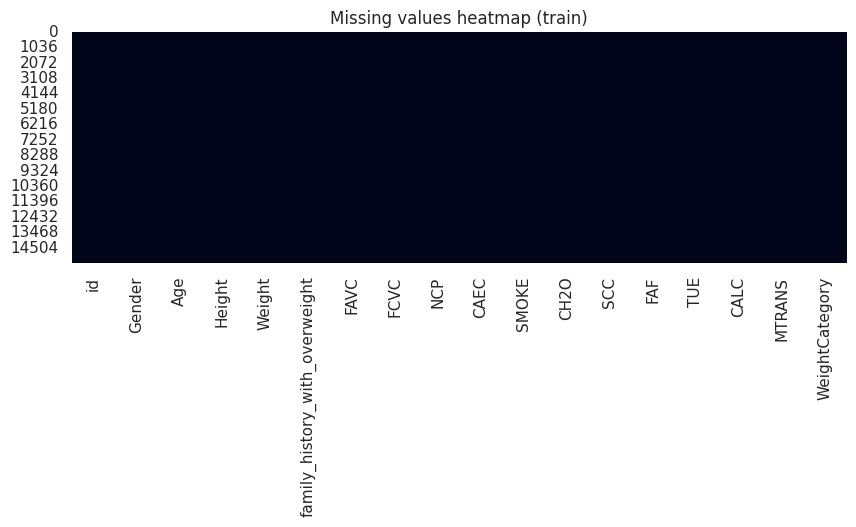

In [43]:
# Missing values
plt.figure(figsize=(10,3))
sns.heatmap(train.isnull(), cbar=False)
plt.title("Missing values heatmap (train)")
plt.show()

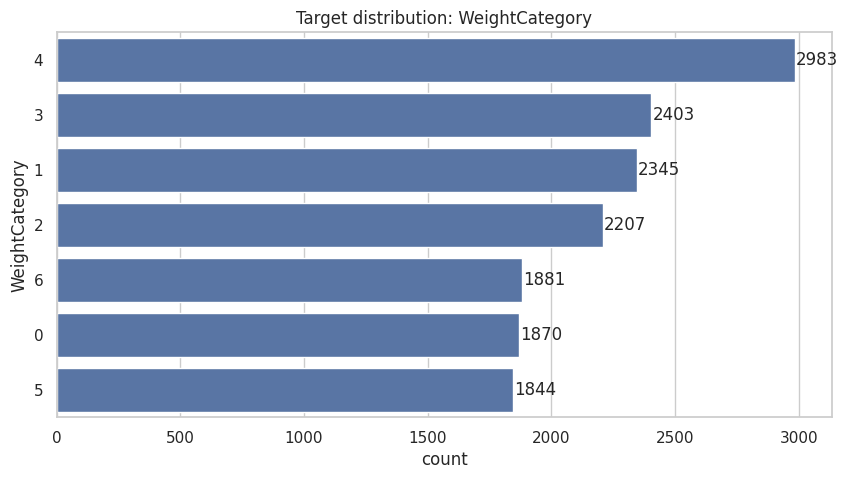

In [44]:
# Target distribution
target_col = 'WeightCategory'
plt.figure(figsize=(10,5))
order = train[target_col].value_counts().index
ax = sns.countplot(y=target_col, data=train, order=order)
plt.title("Target distribution: WeightCategory")
for p in ax.patches:
    ax.text(p.get_width()+5, p.get_y()+p.get_height()/2,
            int(p.get_width()), va='center')
plt.show()


In [45]:

print("\nTarget Class Percentages:")
print((train[target_col].value_counts(normalize=True)*100).round(2))

# Numeric summary
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
display(train[numeric_cols].describe().T)


Target Class Percentages:
WeightCategory
4    19.20
3    15.47
1    15.10
2    14.21
6    12.11
0    12.04
5    11.87
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
id,15533.0,7766.000000,4484.135201,0.00,3883.000000,7766.000000,11649.000000,15532.000000
Age,15533.0,23.816308,5.663167,14.00,20.000000,22.771612,26.000000,61.000000
Height,15533.0,1.699918,0.087670,1.45,1.630927,1.700000,1.762921,1.975663
Weight,15533.0,87.785225,26.369144,39.00,66.000000,84.000000,111.600553,165.057269
family_history_with_overweight,15533.0,0.817357,0.386386,0.00,1.000000,1.000000,1.000000,1.000000
FAVC,15533.0,0.913153,0.281620,0.00,1.000000,1.000000,1.000000,1.000000
FCVC,15533.0,2.442917,0.530895,1.00,2.000000,2.342220,3.000000,3.000000
NCP,15533.0,2.760425,0.706463,1.00,3.000000,3.000000,3.000000,4.000000
CAEC,15533.0,1.151098,0.446058,0.00,1.000000,1.000000,1.000000,3.000000
SMOKE,15533.0,0.011395,0.106141,0.00,0.000000,0.000000,0.000000,1.000000


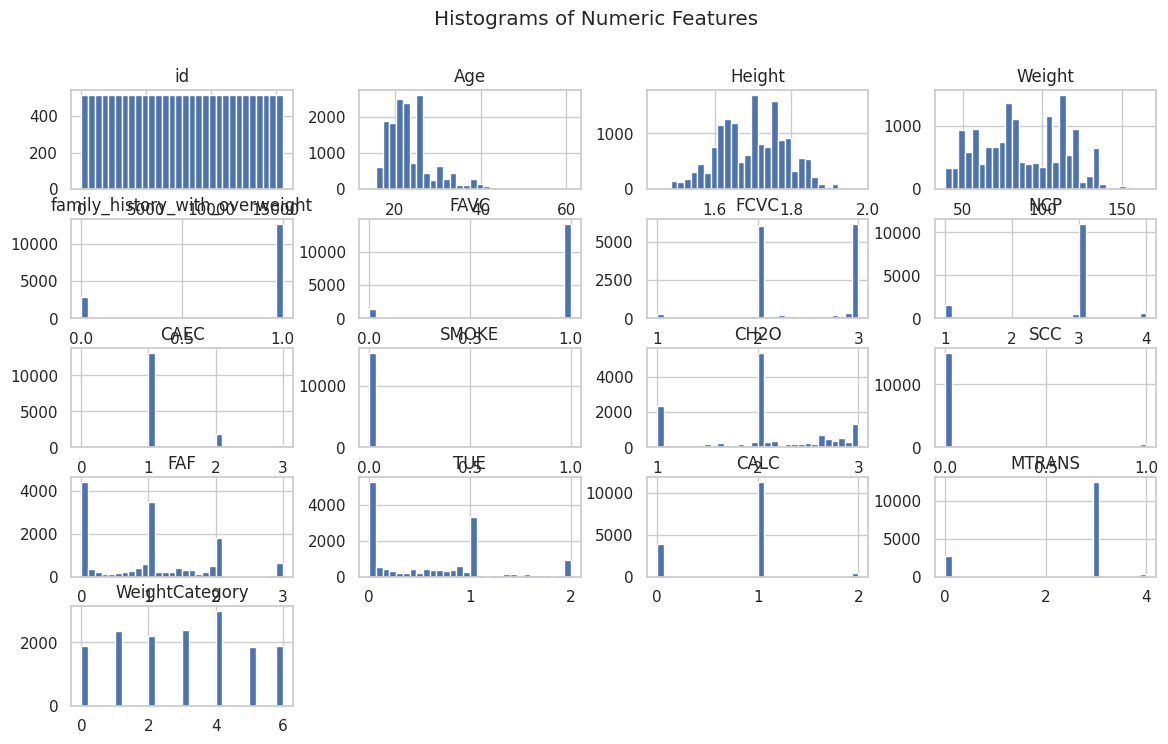

In [46]:
# Histograms
train[numeric_cols].hist(bins=30, figsize=(14,8))
plt.suptitle("Histograms of Numeric Features")
plt.show()

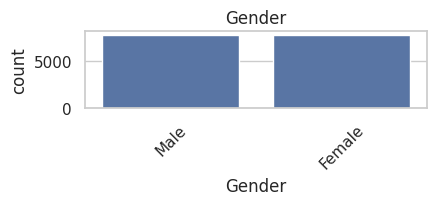

In [47]:
# Categorical feature distributions
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
    plt.figure(figsize=(15,4*len(cat_cols)//3))
    for i, c in enumerate(cat_cols, 1):
        plt.subplot((len(cat_cols)+2)//3, 3, i)
        sns.countplot(x=c, data=train, order=train[c].value_counts().index)
        plt.title(c)
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

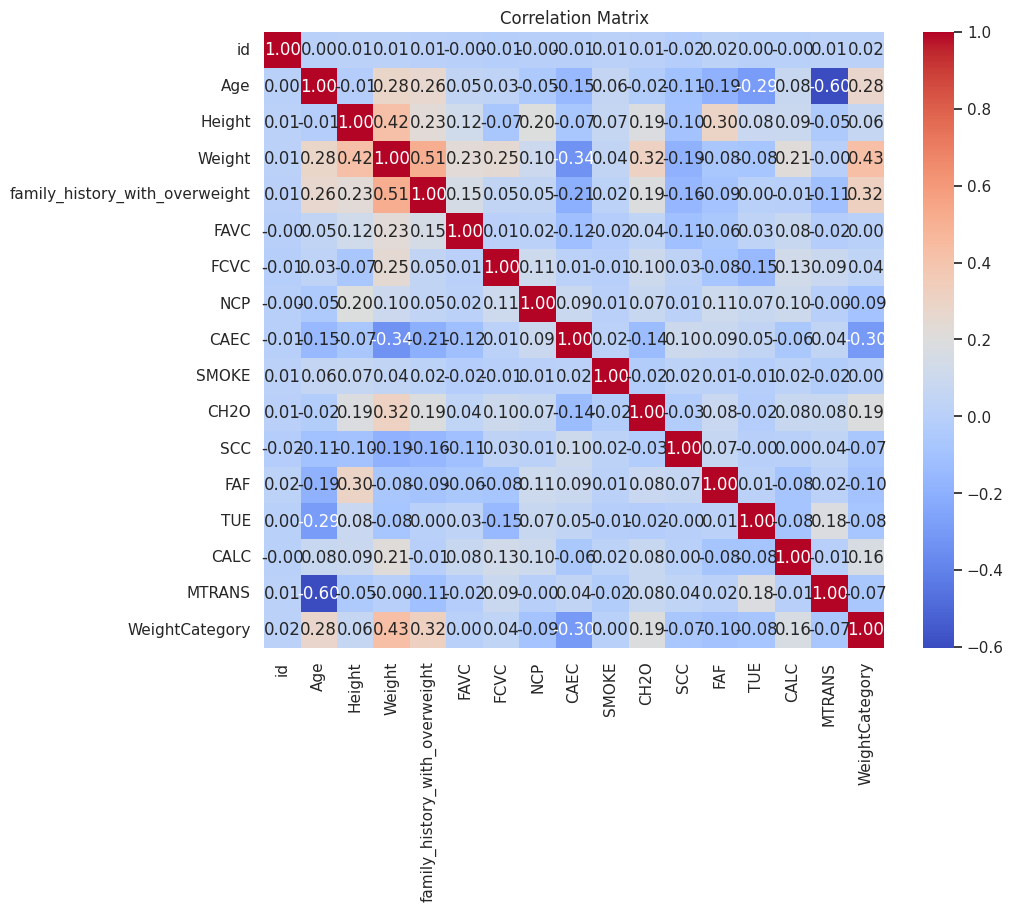

In [48]:
# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(train[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


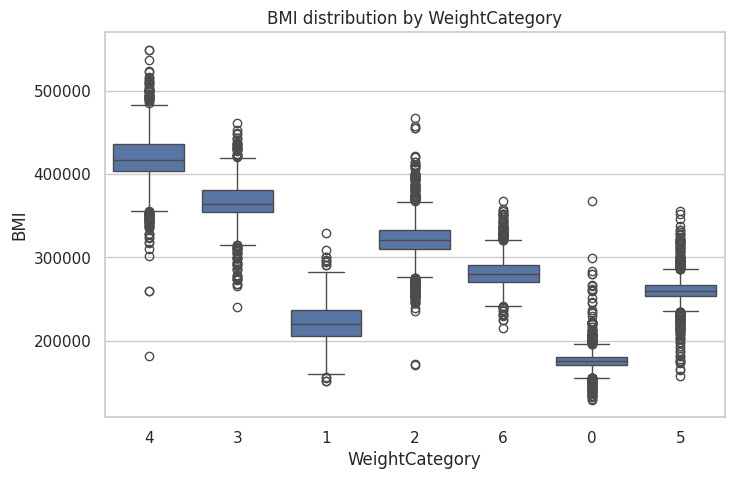

WeightCategory,0,1,2,3,4,5,6
count,1870.000000,2345.000000,2207.000000,2403.000000,2983.000000,1844.000000,1881.000000
mean,176208.069429,220227.886205,321409.896045,365718.139940,418170.010105,260918.382493,282031.880946
std,14360.967040,21992.403195,25631.576473,21144.410780,26903.022934,18002.078553,17973.725467
min,128685.407075,150947.953146,170992.784105,240484.601993,181786.703601,157618.802836,215138.585105
25%,170373.404091,205693.296602,310204.081633,354453.927155,404162.831736,253906.250000,270992.510068
50%,175324.670676,220385.674931,320799.694079,363906.286912,417700.837480,259819.784973,280557.057869
75%,180620.379165,237118.446310,333205.177496,380716.248163,436348.210102,266727.632983,290914.331827
max,367781.150966,328824.141519,468051.876636,462224.831931,549979.913613,355555.555556,367414.556033


In [49]:
# BMI analysis if Height/Weight present
if set(['Height', 'Weight']).issubset(train.columns):
    train['Height_m'] = train['Height'] / 100.0
    train['BMI'] = train['Weight'] / (train['Height_m']**2)
    plt.figure(figsize=(8,5))
    sns.boxplot(x=target_col, y='BMI', data=train, order=order)
    plt.title("BMI distribution by WeightCategory")
    plt.show()
    display(train.groupby(target_col)['BMI'].describe().T)

**Model Evaluation (Validation Performance)**


Best Validation Accuracy: 90.505%

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       374
           1       0.89      0.89      0.89       469
           2       0.89      0.88      0.88       441
           3       0.96      0.97      0.97       481
           4       0.99      1.00      0.99       597
           5       0.81      0.75      0.78       369
           6       0.81      0.84      0.82       376

    accuracy                           0.91      3107
   macro avg       0.90      0.90      0.90      3107
weighted avg       0.90      0.91      0.90      3107



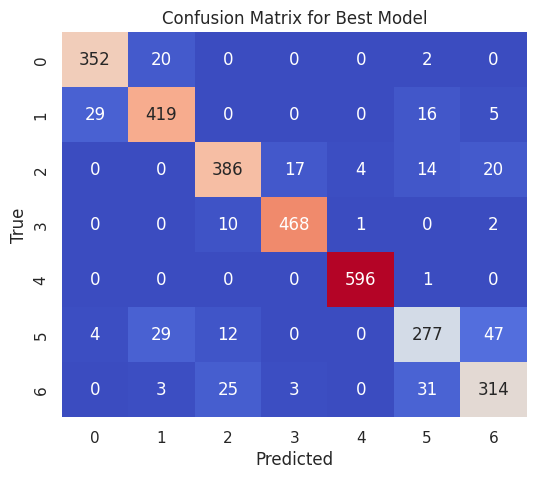

In [50]:
y_pred = best_model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)

print(f"\nBest Validation Accuracy: {acc*100:.3f}%")
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title("Confusion Matrix for Best Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**Accuracy vs n_estimators Plot**

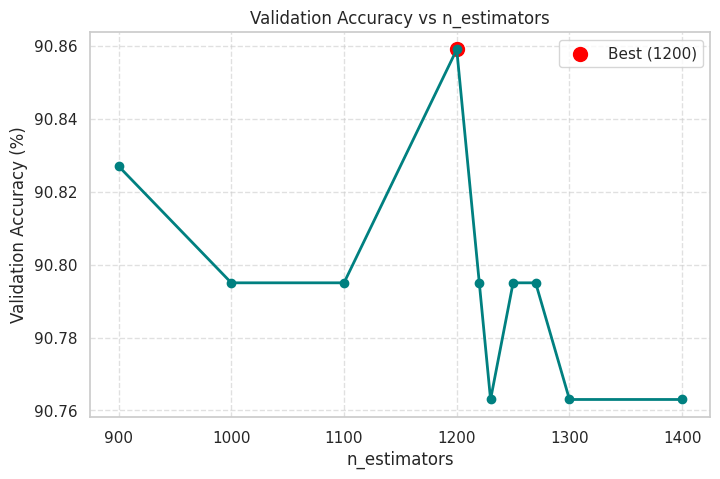

In [51]:
accuracy_list = [90.827, 90.795, 90.795, 90.859, 90.795, 90.763, 90.795, 90.795, 90.763, 90.763]

plt.figure(figsize=(8,5))
plt.plot(n_estimator_values, accuracy_list, marker='o', color='teal', linewidth=2)
plt.title("Validation Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Validation Accuracy (%)")
plt.grid(True, linestyle='--', alpha=0.6)

best_idx = accuracy_list.index(max(accuracy_list))
plt.scatter(n_estimator_values[best_idx], accuracy_list[best_idx],
            color='red', s=100, label=f"Best ({n_estimator_values[best_idx]})")
plt.legend()
plt.show()
